<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Load-predictions-and-GT" data-toc-modified-id="Load-predictions-and-GT-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load predictions and GT</a></span></li><li><span><a href="#Static-thresholds" data-toc-modified-id="Static-thresholds-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Static thresholds</a></span></li><li><span><a href="#NumThresh" data-toc-modified-id="NumThresh-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>NumThresh</a></span></li><li><span><a href="#SGLthresh" data-toc-modified-id="SGLthresh-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SGLthresh</a></span></li><li><span><a href="#heuThresh" data-toc-modified-id="heuThresh-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>heuThresh</a></span></li></ul></div>

In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support, classification_report

import pickle
import time
import tqdm

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device, torch.cuda.get_device_name(0))

print("pytorch version:", torch.__version__)


cuda:0 GeForce GTX 1080
pytorch version: 1.4.0


In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True

In [3]:
def print_scores(gt_y, preds):
    print(classification_report(gt_y, preds, digits=3))    
    set_accuracy = accuracy_score(gt_y, preds)
    print('set acc: %.3f'%(set_accuracy))


def print_thresholds(thresh, nb_classes):
    s=''
    for k in range(nb_classes):
        s += '%.3f '%(thresh[k])
    print(s)

    
def save_thresholds_to_text(thresh, fpath):
    nb_classes = len(thresh)
    print(nb_classes)
    with open(fpath, 'wt') as fh:
        for k in range(nb_classes):
            fh.write("%.6f\n"%(thresh[k]))
            
            
def save_thresholds(thresh, fpath):
    np.save(fpath, np.array(thresh))
            

def load_thresholds(fpath):
    return np.load(fpath)


def binarize_probs(probs, thresholds):
    
    nb_classes = probs.shape[-1]
    binarized_output = np.zeros_like(probs)
    
    for k in range(nb_classes):
        binarized_output[:, k] = (np.sign(probs[:, k] - thresholds[k]) + 1) // 2
    
    return binarized_output


# Load predictions and GT

In [4]:
val_pred_tensor = torch.load('datasets/dcase2019/predictions_tensor_validation.pt')
val_gt_tensor = torch.load('datasets/dcase2019/gt_tensor_validation.pt')
val_pred_np = val_pred_tensor.clone().cpu().numpy()
val_gt_np = val_gt_tensor.clone().cpu().numpy()

desed_pred_tensor = torch.load('datasets/dcase2019/predictions_tensor_desed.pt')
desed_gt_tensor = torch.load('datasets/dcase2019/gt_tensor_desed.pt')
desed_pred_np = desed_pred_tensor.clone().cpu().numpy()
desed_gt_np = desed_gt_tensor.clone().cpu().numpy()

nb_classes=val_gt_tensor.size(1)
print(nb_classes)

val_pred_tensor.size(), val_gt_tensor.size(), val_pred_np.shape, val_gt_np.shape, desed_pred_tensor.size(), desed_gt_tensor.size(), desed_pred_np.shape, desed_gt_np.shape

10


(torch.Size([1122, 10]),
 torch.Size([1122, 10]),
 (1122, 10),
 (1122, 10),
 torch.Size([692, 10]),
 torch.Size([692, 10]),
 (692, 10),
 (692, 10))

(array([866.,  92.,  33.,  16.,  22.,  11.,  13.,  13.,  23.,  33.]),
 array([1.1649572e-05, 9.8498344e-02, 1.9698504e-01, 2.9547173e-01,
        3.9395842e-01, 4.9244511e-01, 5.9093183e-01, 6.8941849e-01,
        7.8790522e-01, 8.8639188e-01, 9.8487860e-01], dtype=float32),
 <a list of 10 Patch objects>)

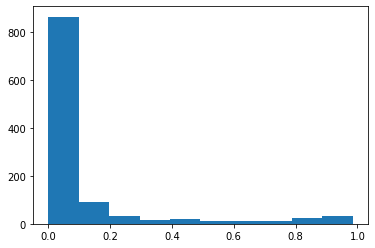

In [4]:
plt.hist(val_pred_np[:,9])

In [78]:
noise = torch.normal(mean=0.1*torch.ones(val_pred_np.shape), std=0.1)
noise = torch.clamp(noise, 0, 1)

(array([315., 201., 178., 178., 117.,  80.,  36.,  11.,   5.,   1.]),
 array([0.        , 0.04407002, 0.08814005, 0.13221008, 0.1762801 ,
        0.22035012, 0.26442015, 0.30849016, 0.3525602 , 0.3966302 ,
        0.44070023], dtype=float32),
 <a list of 10 Patch objects>)

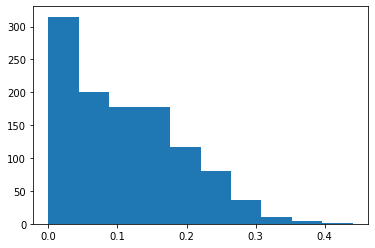

In [79]:
plt.hist(noise[:,0].cpu().numpy())

# Static thresholds

In [5]:
static_thresh = 0.5

val_bin_pred = binarize_probs(val_pred_np, [static_thresh]*nb_classes)
test_bin_pred = binarize_probs(desed_pred_np, [static_thresh]*nb_classes)

In [6]:
print("val")
print_scores(val_gt_np, val_bin_pred)
print("test")
print_scores(desed_gt_np, test_bin_pred)

# f1 = f1_score(val_gt_np, val_bin_pred, average='micro')
# print("%.3f"%f1)

# myf1 = my_calculate_f1(val_gt_np, val_pred_np, thresholds=[static_thresh]*nb_classes, average='micro')
# print("%.3f"%myf1)

# binarized_output = np.zeros_like(val_gt_np)
#     #     print('class num:', classes_num)
# thresholds=[static_thresh]*nb_classes
# for k in range(nb_classes):
#     binarized_output[:, k] = (np.sign(val_pred_np[:, k] - thresholds[k]) + 1) // 2

# np.allclose(val_bin_pred, binarized_output)
# # val_bin_pred[:10], binarized_output[:10]

val
              precision    recall  f1-score   support

           0      0.882     0.806     0.843       186
           1      0.902     0.905     0.903       599
           2      0.727     0.550     0.626       160
           3      0.810     0.533     0.643       120
           4      0.470     0.780     0.587        91
           5      0.659     0.403     0.500       144
           6      0.351     0.698     0.467        86
           7      0.322     0.758     0.452        62
           8      0.479     0.425     0.450        80
           9      0.892     0.428     0.578       194

   micro avg      0.708     0.695     0.701      1722
   macro avg      0.650     0.629     0.605      1722
weighted avg      0.765     0.695     0.707      1722
 samples avg      0.698     0.708     0.683      1722

set acc: 0.452
test
              precision    recall  f1-score   support

           0      0.905     0.722     0.803        79
           1      0.846     0.911     0.877       314


/home/thomas/tools/miniconda2/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# NumThresh

In [8]:
from sgl_utils.opt import Adam
from sgl_utils.numThresh import calculate_f1, calculate_at_gradient, optimize_at_with_gd, optimize_prec_and_rec_with_gd, calculate_prec_and_rec_gradient, calculate_prec_and_rec
from sklearn import metrics

In [9]:
t=0.5
thresh = [t]*nb_classes

average = 'micro'

manual_thres_f1 = calculate_f1(val_gt_np, val_pred_np, thresholds=thresh, average=average)
# print_scores(y_test_numpy, test_pred)

# Optimize thresholds
(auto_thres_f1, auto_thresholds, metric_asfo_epoch) = optimize_at_with_gd(val_gt_np, val_pred_np, 
                                                                          thresh, average=average)
# (auto_thres_f1, auto_thresholds, metric_asfo_epoch) = optimize_prec_and_rec_with_gd(val_gt_np, val_pred_np, 
#                                                                           thresh, average=average)

# print_thresholds(auto_thresholds, nb_classes)
# print("%.3f %.3f"%(manual_thres_f1*100, fscore2*100))

print('val manual_thres f1: {:.3f}'.format(manual_thres_f1))
print('val auto_thres f1: {:.3f}'.format(auto_thres_f1))

print(auto_thres_f1)
print_thresholds(auto_thresholds, nb_classes)


Iteration: 0, Score: 0.702, thresholds: [0.49039758 0.49000861 0.49000383 0.50955791 0.50994789 0.50988375
 0.50695256 0.50988375 0.50988375 0.49015927]
Iteration: 50, Score: 0.714, thresholds: [0.48184331 0.4949478  0.4892257  0.51646184 0.66173731 0.51961189
 0.83845614 0.54690435 0.50881263 0.46643814]
val manual_thres f1: 0.701
val auto_thres f1: 0.714
0.7142857142857143
0.487 0.493 0.491 0.515 0.662 0.520 0.826 0.545 0.509 0.446 


(array([0.7  , 0.702, 0.704, 0.706, 0.708, 0.71 , 0.712, 0.714, 0.716]),
 <a list of 9 Text yticklabel objects>)

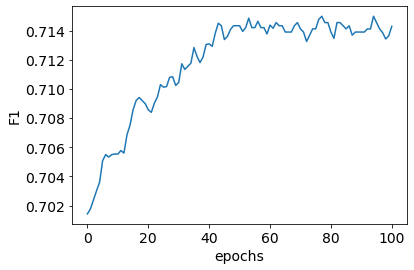

In [10]:
fontsize=14
plt.plot(metric_asfo_epoch)
plt.xlabel("epochs", fontsize=fontsize)
plt.ylabel("F1", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.savefig("datasets/emotions/emotions_F1_asof_epochs_myNetwork.png")

In [56]:
# print_thresholds(learned_AT_thresholds, nb_classes)

val_bin_pred = binarize_probs(val_pred_np, auto_thresholds)
test_bin_pred = binarize_probs(desed_pred_np, auto_thresholds)

print('val')
print_scores(val_gt_np, val_bin_pred)
print('desed')
print_scores(desed_gt_np, test_bin_pred)

# val
#               precision    recall  f1-score   support

#            0      0.840     0.817     0.828       186
#            1      0.849     0.937     0.890       599
#            2      0.590     0.613     0.601       160
#            3      0.753     0.583     0.657       120
#            4      0.560     0.714     0.628        91
#            5      0.503     0.590     0.543       144
#            6      0.477     0.488     0.483        86
#            7      0.287     0.790     0.421        62
#            8      0.417     0.500     0.455        80
#            9      0.763     0.515     0.615       194

#    micro avg      0.674     0.733     0.702      1722
#    macro avg      0.604     0.655     0.612      1722
# weighted avg      0.704     0.733     0.709      1722
#  samples avg      0.691     0.746     0.694      1722

# set acc: 0.436
# desed
#               precision    recall  f1-score   support

#            0      0.873     0.785     0.827        79
#            1      0.760     0.927     0.835       314
#            2      0.691     0.793     0.739        82
#            3      0.845     0.700     0.766        70
#            4      0.660     0.681     0.670        94
#            5      0.785     0.618     0.691       136
#            6      0.698     0.420     0.525        88
#            7      0.574     0.881     0.695        84
#            8      0.566     0.589     0.577        73
#            9      0.597     0.500     0.544        92

#    micro avg      0.712     0.733     0.722      1112
#    macro avg      0.705     0.689     0.687      1112
# weighted avg      0.718     0.733     0.715      1112
#  samples avg      0.713     0.738     0.706      1112

# set acc: 0.471

# micro avg      0.681     0.729     0.704      1722

val
              precision    recall  f1-score   support

           0      0.882     0.806     0.843       186
           1      0.899     0.907     0.903       599
           2      0.714     0.562     0.629       160
           3      0.821     0.533     0.646       120
           4      0.559     0.725     0.632        91
           5      0.704     0.396     0.507       144
           6      0.477     0.488     0.483        86
           7      0.326     0.758     0.456        62
           8      0.479     0.425     0.450        80
           9      0.853     0.448     0.588       194

   micro avg      0.746     0.685     0.714      1722
   macro avg      0.671     0.605     0.614      1722
weighted avg      0.774     0.685     0.712      1722
 samples avg      0.719     0.701     0.689      1722

set acc: 0.461
desed
              precision    recall  f1-score   support

           0      0.906     0.734     0.811        79
           1      0.846     0.911     0.877       314

/home/thomas/tools/miniconda2/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
def calf1(y_true, output, thresholds, average):
    """Calculate F1 score.
    Args:
      y_true: (N, (optional)frames_num], classes_num)
      output: (N, (optional)[frames_num], classes_num)
      thresholds: (classes_num,), initial thresholds
      average: 'micro' | 'macro'
    """
    if y_true.ndim == 3:
        (N, T, F) = y_true.shape
        y_true = y_true.reshape((N * T, F))
        output = output.reshape((N * T, F))

    classes_num = y_true.shape[-1]
    #     print('class num:', classes_num)
    binarized_output = 1*(output>thresholds)
    return metrics.f1_score(y_true.flatten(), binarized_output.flatten())


def calf1_for_loop(y_true, output, thresholds, average):
    if y_true.ndim == 3:
        (N, T, F) = y_true.shape
        y_true = y_true.reshape((N * T, F))
        output = output.reshape((N * T, F))

    classes_num = y_true.shape[-1]
    binarized_output = np.zeros_like(output)
    #     print('class num:', classes_num)

    for k in range(classes_num):
        binarized_output[:, k] = (np.sign(output[:, k] - thresholds[k]) + 1) // 2

    return metrics.f1_score(y_true.flatten(), binarized_output.flatten())


In [33]:
def softmax(x):
    toto = np.exp(x)
    return toto/np.sum(toto, axis=1,keepdims=True)

def sigmoid(x):
    return 1./(1+np.exp(-x))

In [65]:
C = 10000
N = 10000
tmp = np.random.rand(N,C)
# tmp = softmax(tmp)
# np.sum(tmp, axis=1)
tmp = sigmoid(tmp)

# create ground-truth
gt = np.random.randint(low=0, high=2, size=(N,C))

thresholds = [0.5]*C

deb = time.time()
f1 = calf1(gt, tmp, thresholds, 'micro')
print("no for loop: %.2f"%(time.time()-deb))
deb = time.time()
other_f1 = calf1_for_loop(gt, tmp, thresholds, 'micro')
print("for loop: %.2f"%(time.time()-deb))


# C = 500
# N = 10000
# no for loop: 2.09
# for loop: 2.70

# C = 500
# N = 50000
# no for loop: 10.98
# for loop: 14.59

# C = 500
# N = 100000
# no for loop: 24.36
# for loop: 27.88

# C = 10
# N = 10000
# no for loop: 0.05
# for loop: 0.05

# C = 100
# N = 10000    
# no for loop: 0.34
# for loop: 0.43

# C = 1000
# N = 10000
# no for loop: 4.34
# for loop: 5.63
    
# C = 10000
# N = 10000
# no for loop: 50.84
# for loop: 61.95
    
f1, other_f1

no for loop: 50.84
for loop: 61.95


(0.666607055112744, 0.666607055112744)

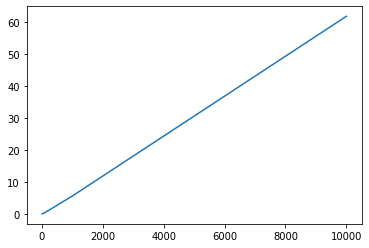

In [66]:
# x = [10000, 50000, 100000]
# y = [2.70, 14.59, 27.88]

x = [10, 100, 1000, 10000]
y = [0.05, 0.43, 5.63, 61.95]


plt.plot(x,y)

In [21]:
# val
#               precision    recall  f1-score   support

#            0      0.835     0.817     0.826       186
#            1      0.856     0.932     0.892       599
#            2      0.594     0.613     0.603       160
#            3      0.764     0.567     0.651       120
#            4      0.371     0.802     0.507        91
#            5      0.503     0.576     0.537       144
#            6      0.297     0.733     0.423        86
#            7      0.282     0.790     0.415        62
#            8      0.389     0.525     0.447        80
#            9      0.763     0.515     0.615       194

#    micro avg      0.620     0.747     0.677      1722
#    macro avg      0.565     0.687     0.592      1722
# weighted avg      0.687     0.747     0.699      1722
#  samples avg      0.651     0.757     0.677      1722

# set acc: 0.386
# test
#               precision    recall  f1-score   support

#            0      0.875     0.797     0.834        79
#            1      0.765     0.924     0.837       314
#            2      0.691     0.793     0.739        82
#            3      0.842     0.686     0.756        70
#            4      0.500     0.798     0.615        94
#            5      0.786     0.596     0.678       136
#            6      0.438     0.648     0.523        88
#            7      0.565     0.881     0.688        84
#            8      0.529     0.616     0.570        73
#            9      0.611     0.478     0.537        92

#    micro avg      0.661     0.757     0.706      1112
#    macro avg      0.660     0.722     0.678      1112
# weighted avg      0.683     0.757     0.708      1112
#  samples avg      0.684     0.764     0.701      1112

# set acc: 0.422

# SGLthresh

In [11]:
from sgl_utils.sglThresh import ThresholdModel, SurrogateHeaviside, F1_loss_objective, setAcc_loss_objective

Device in sglThresh.py cuda:0


In [12]:
nb_classes = 10
criterion = F1_loss_objective
# criterion = setAcc_loss_objective

THRESHmodel = ThresholdModel(threshold_fn=SurrogateHeaviside.apply, t=0.5, sigma=50., nb_classes=nb_classes)
THRESHmodel = THRESHmodel.to(device, dtype=torch.float)

# for el in THRESHmodel.parameters():
#     params = el.clone().detach().cpu()
#     print(params)

thresh = THRESHmodel.thresh
sigma = THRESHmodel.sigma
print(thresh)
print(sigma)

learning_rate = 1e-2

THRESHoptimizer = torch.optim.Adam(THRESHmodel.parameters(), lr=learning_rate)

# # # learn only the thresholds:
# THRESHoptimizer = torch.optim.Adam([
#                 {'params': THRESHmodel.thresh}
#             ], lr=learning_rate)

# # learn the thresholds and sigma:
# THRESHoptimizer = torch.optim.Adam([
#                 {'params': THRESHmodel.thresh},
#                 {'params': THRESHmodel.sigma, 'lr': 1e-2}
#             ], lr=learning_rate)


Parameter containing:
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([50., 50., 50., 50., 50., 50., 50., 50., 50., 50.], device='cuda:0',
       requires_grad=True)


tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000])
Epoch [1/100], Loss: -0.7014, Duration: 0.0 s
threshs: tensor([0.4900, 0.5100, 0.4900, 0.4900, 0.5100, 0.4900, 0.5100, 0.5100, 0.5100,
        0.4900])
sigma: tensor([50.0100, 50.0100, 50.0100, 49.9901, 50.0100, 49.9902, 50.0100, 50.0100,
        50.0100, 50.0100])
Epoch [2/100], Loss: -0.7006, Duration: 0.0 s
Epoch [3/100], Loss: -0.7020, Duration: 0.0 s
Epoch [4/100], Loss: -0.7043, Duration: 0.0 s
Epoch [5/100], Loss: -0.7054, Duration: 0.0 s
Epoch [6/100], Loss: -0.7061, Duration: 0.0 s
Epoch [7/100], Loss: -0.7071, Duration: 0.0 s
Epoch [8/100], Loss: -0.7091, Duration: 0.0 s
Epoch [9/100], Loss: -0.7104, Duration: 0.0 s
Epoch [10/100], Loss: -0.7119, Duration: 0.0 s
Epoch [11/100], Loss: -0.7128, Duration: 0.0 s
threshs: tensor([0.4913, 0.5991, 0.4507, 0.3976, 0.6091, 0.3921, 0.6102, 0.6066, 0.5992,
        0.3913])
sigma: tensor([50.1095, 50.0948, 50.1092, 49.9905, 50.0920, 49.9809, 

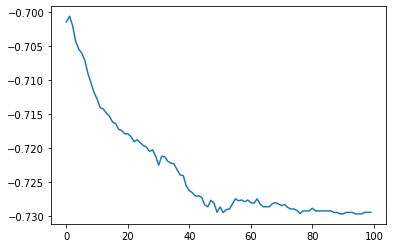

In [13]:
# Train the model, in batch mode
# num_epochs = 150
num_epochs = 100
# num_epochs = 300

# sigma = torch.nn.Parameter(torch.tensor(40.0), requires_grad=True)

cumul_delta_thresh = torch.zeros(nb_classes,)
delta_thresh = torch.zeros(nb_classes,)

el = next(THRESHmodel.parameters())
PREC_learned_AT_thresholds = el.clone().detach().cpu()
print(PREC_learned_AT_thresholds)
    
losses = []
for epoch in range(num_epochs):
    
    debut = time.time()
    
    THRESHmodel.train()
    
    # Forward pass
    outputs = THRESHmodel(val_pred_tensor)

    loss = criterion(outputs, val_gt_tensor)

    # Backward and optimize
    THRESHoptimizer.zero_grad()

    loss.backward()
#     loss.mean().backward()
#         loss.backward(at_batch_y)
    # loss.backward(torch.ones_like(loss))
    
    THRESHoptimizer.step()
    # THRESHmodel.clamp()
    losses.append(loss)
    
    duree_epoch = time.time() - debut

    print ('Epoch [{}/{}], Loss: {:.4f}, Duration: {:.1f} s' 
           .format(epoch+1, num_epochs, loss, duree_epoch))

    learned_AT_thresholds = THRESHmodel.thresh.clone().detach().cpu()

    delta_thresh = learned_AT_thresholds - PREC_learned_AT_thresholds
    cumul_delta_thresh += delta_thresh
    PREC_learned_AT_thresholds = learned_AT_thresholds
    if epoch % 10 == 0: 
        print('threshs:', learned_AT_thresholds)
        print('sigma:', THRESHmodel.sigma.clone().detach().cpu())
    # if torch.sum(delta_thresh) < 0.01: break
    
print('delta:', cumul_delta_thresh)
plt.figure()
# plt.figure(figsize=(8,6))
plt.plot(losses)

In [14]:
learned_AT_thresholds=THRESHmodel.thresh.clone().detach().cpu().numpy()
sigma = THRESHmodel.sigma.clone().detach().cpu().numpy()
learned_AT_thresholds, sigma
# numThresh: 0.317 0.276 0.299 0.248 0.680 0.292 0.828 0.334 0.352 0.280 
# sglThresh: 0.486 0.581 0.468 0.380 0.671 0.403 0.844 0.950 0.597 0.350 
# heuThresh: 0.470 0.638 0.495 0.135 0.665 0.389 0.803 0.987 0.365 0.202 

print_thresholds(learned_AT_thresholds, nb_classes)

0.486 0.581 0.468 0.380 0.671 0.403 0.844 0.950 0.597 0.350 


In [15]:
# print_thresholds(learned_AT_thresholds, nb_classes)
# val_bin_pred = val_pred_np>learned_AT_thresholds
# test_bin_pred = desed_pred_np>learned_AT_thresholds

val_bin_pred = binarize_probs(val_pred_np, learned_AT_thresholds)
test_bin_pred = binarize_probs(desed_pred_np, learned_AT_thresholds)

# print(val_bin_pred)

print('val')
print_scores(val_gt_np, val_bin_pred)
print('desed')
print_scores(desed_gt_np, test_bin_pred)
# compute_accuracy_from_numpy_tensors(y_test_numpy, test_pred)
# 0.3366 0.2834 0.2761 0.3185 0.2849 0.2611

val
              precision    recall  f1-score   support

           0      0.882     0.806     0.843       186
           1      0.917     0.898     0.907       599
           2      0.700     0.569     0.628       160
           3      0.788     0.558     0.654       120
           4      0.559     0.725     0.632        91
           5      0.615     0.521     0.564       144
           6      0.482     0.465     0.473        86
           7      0.494     0.645     0.559        62
           8      0.516     0.400     0.451        80
           9      0.808     0.500     0.618       194

   micro avg      0.768     0.695     0.729      1722
   macro avg      0.676     0.609     0.633      1722
weighted avg      0.772     0.695     0.725      1722
 samples avg      0.737     0.710     0.700      1722

set acc: 0.480
desed
              precision    recall  f1-score   support

           0      0.906     0.734     0.811        79
           1      0.863     0.901     0.882       314

/home/thomas/tools/miniconda2/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# myf1 = calculate_f1(desed_gt_np, desed_pred_np, thresholds=learned_AT_thresholds, average='micro')
# print("%.3f"%myf1)


0.719


# heuThresh

In [7]:
from heu_utils.heuThresh import heu_threshold_opti, heu_threshold_opti_meanF1

In [9]:
t=0.5
thresh = [t]*nb_classes

# sk_f1, best_f1, best_AT_thresholds, history = heu_threshold_opti(val_gt_np, val_pred_np, thresh)

# average F1 optim:
sk_f1, best_f1, best_AT_thresholds, history = heu_threshold_opti_meanF1(val_gt_np, val_pred_np, thresh, average='micro')

In [10]:
val_bin_pred = binarize_probs(val_pred_np, best_AT_thresholds)
test_bin_pred = binarize_probs(desed_pred_np, best_AT_thresholds)

# print(val_bin_pred)

print('val')
print_scores(val_gt_np, val_bin_pred)
print('desed')
print_scores(desed_gt_np, test_bin_pred)


val
              precision    recall  f1-score   support

           0      0.873     0.812     0.841       186
           1      0.924     0.891     0.907       599
           2      0.681     0.575     0.624       160
           3      0.795     0.550     0.650       120
           4      0.532     0.736     0.618        91
           5      0.792     0.264     0.396       144
           6      0.432     0.593     0.500        86
           7      0.455     0.645     0.533        62
           8      0.525     0.388     0.446        80
           9      0.817     0.485     0.608       194

   micro avg      0.764     0.676     0.717      1722
   macro avg      0.683     0.594     0.612      1722
weighted avg      0.783     0.676     0.709      1722
 samples avg      0.735     0.698     0.695      1722

set acc: 0.471
desed
              precision    recall  f1-score   support

           0      0.896     0.759     0.822        79
           1      0.870     0.898     0.884       314

In [49]:
save_thresholds(best_AT_thresholds, "exp/dcase2019/heu_thresholds_meanF1_micro.npy")

In [54]:
tmp = load_thresholds("exp/dcase2019/heu_thresholds_meanF1_micro.npy")
tmp

array([0.4742253 , 0.63817557, 0.4951682 , 0.13649258, 0.66349847,
       0.38909076, 0.80260752, 0.98742909, 0.36431398, 0.20225315])

In [78]:
print_thresholds(best_AT_thresholds, nb_classes)

0.470 0.638 0.495 0.135 0.665 0.389 0.803 0.987 0.365 0.202 
